<h1>Baseline</h1>
<p>
    A baseline model is a simple model use to guage and provide insights to build complicated models. This baseline model specifically will uses data from a window of time to predict the value of cryptocurrency.
</p>

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as ma

%matplotlib inline

In [93]:
def get_csv(path: str) -> pd.DataFrame:

    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})

    
def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def plot_graph(*args, title: str = None, colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], **kwargs) -> None:

    plt.figure(figsize = (20, 6))
    number_of_graph = 0
    
    if title is not None:
        plt.title(title)

    for arg in args:
        plt.plot(arg, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

In [94]:
df_ada = get_csv('./data/cardano.csv')

---

<h3>Implementing the Baseline Model</h3>
<p>
    Below is the implementation of Control regression if the form of a python class. The class methods mimic scikit-learn models.
    <br/>
    The model basically find the mean of the fitted dataset and use that as the predicted value.
</p>

In [95]:
class BaselineRegression:

    def fit(self, x: pd.DataFrame, y: np.ndarray) -> None:
        self.__train_y = y

    def predict(self, x: pd.DataFrame) -> np.ndarray:
        return np.array([np.mean(self.__train_y) for _ in x.index])

---

<h3>Testing</h3>

In [96]:
x_train_ada = df_ada[['low', 'high']][:ma.floor(df_ada.shape[0] * 0.7)]
y_train_ada = df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)]
x_test_ada = df_ada[['low', 'high']][ma.floor(df_ada.shape[0] * 0.7):]
y_test_ada = df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

In [97]:
model = BaselineRegression()
model.fit(x_train_ada, y_train_ada)
pred = pd.Series(model.predict(y_test_ada), index = y_test_ada.index)

19.431590865873474 %


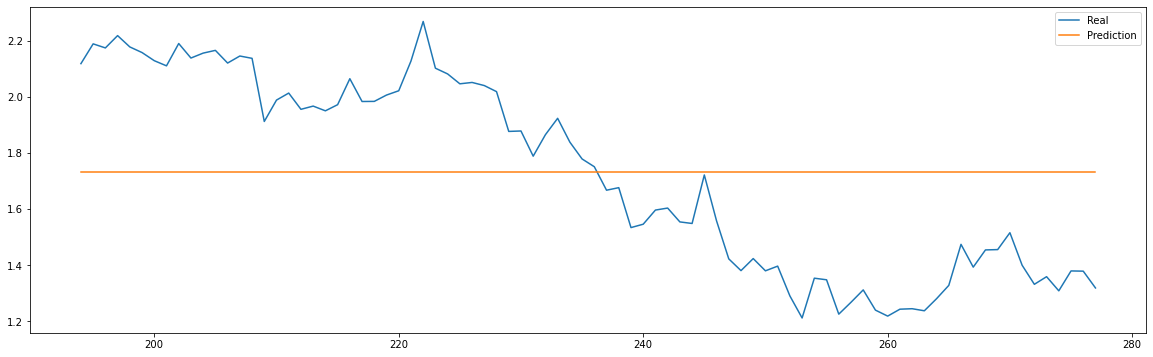

In [111]:
print(MAPE(pred, y_test_ada) * 100, '%')
plot_graph(Real = y_test_ada, Prediction = pred)

---

<h3>Applying Rolling Forecast</h3>
<p>
    The error of the baseline model above is around: 19.4%. The problem's that the model's using the whole dataset mean as its predicted values, a constant value. The model could do better. By applying rolling forecast, the mean of the training data will move around, thus giving a more accurate prediction.
    <br/>
    In this case the model will makes predictions based on a 7 days-window mean.
</p>

In [99]:
def rolling_control(df: pd.DataFrame, window: int = 7 ,test_ratio: float = 0.3) -> pd.DataFrame:
    x_test = df[['low', 'high']][ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.DataFrame(columns = ['date', 'pred', 'real'])
    model = BaselineRegression()

    for i in x_test.index:
        x_train = df[['low', 'high']][i - window:i]
        y_train = df['price'][i - window:i]
        model.fit(x_train, y_train)
        pred.loc[i] = {'date': df.loc[i]['date'], 'real': df.loc[i]['price'], 'pred': model.predict(x_test.loc[[i]])[0]}

    return pred.set_index('date')

In [100]:
rolling_ada = rolling_control(df_ada)

4.938090674888718 %


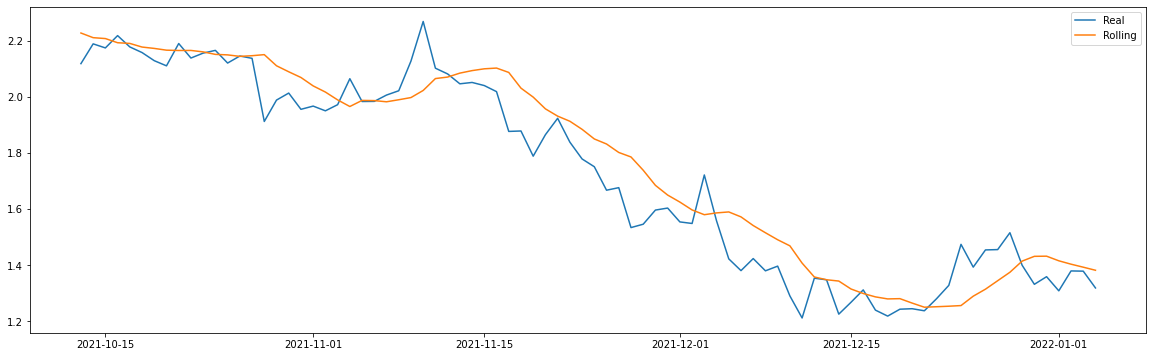

In [101]:
print(MAPE(rolling_ada['pred'], rolling_ada['real']) * 100, '%')
plot_graph(Real = rolling_ada['real'], Rolling = rolling_ada['pred'])

<p>
    The accuracy improved significantly, the error is now as low as 4.94%.
</p>

---

<h3>ETH</h3>

In [102]:
df_eth = get_csv('./data/ethereum.csv')

In [103]:
eth_rolling = rolling_control(df_eth)

6.381071789544535 %


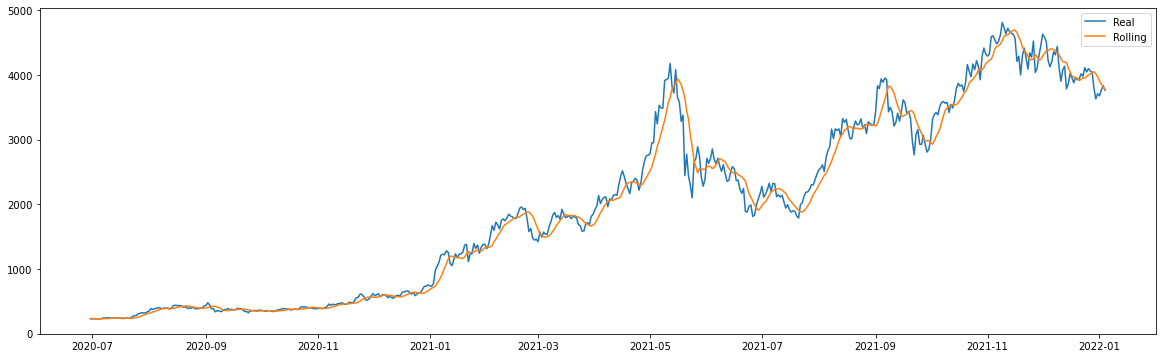

In [104]:
print(MAPE(eth_rolling['pred'], eth_rolling['real']) * 100, '%')
plot_graph(Real = eth_rolling['real'], Rolling = eth_rolling['pred'])

---

<h3>DOGE</h3>

In [105]:
df_doge = get_csv('./data/dogecoin.csv')

In [106]:
doge_rolling = rolling_control(df_doge)

8.92864570773257 %


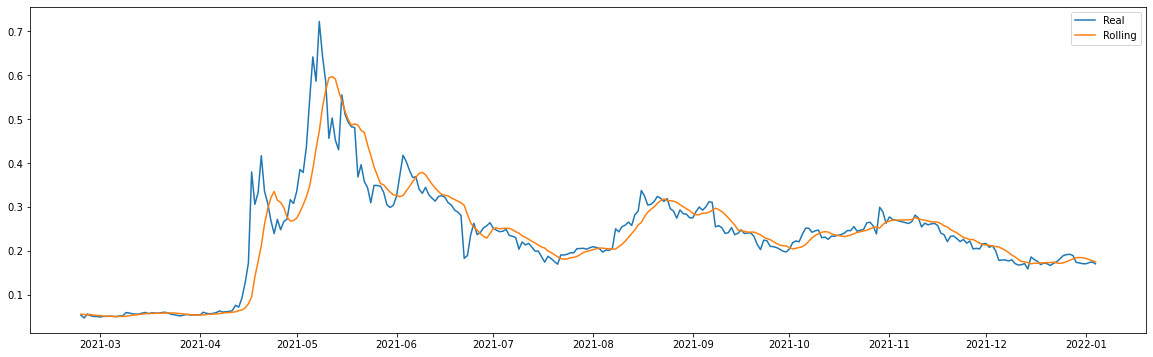

In [107]:
print(MAPE(doge_rolling['pred'], doge_rolling['real']) * 100, '%')
plot_graph(Real = doge_rolling['real'], Rolling = doge_rolling['pred'])

---

<h3>SOL</h3>

In [108]:
df_sol =  get_csv('./data/solana.csv')

In [109]:
sol_rolling = rolling_control(df_sol)

6.804281743156635 %


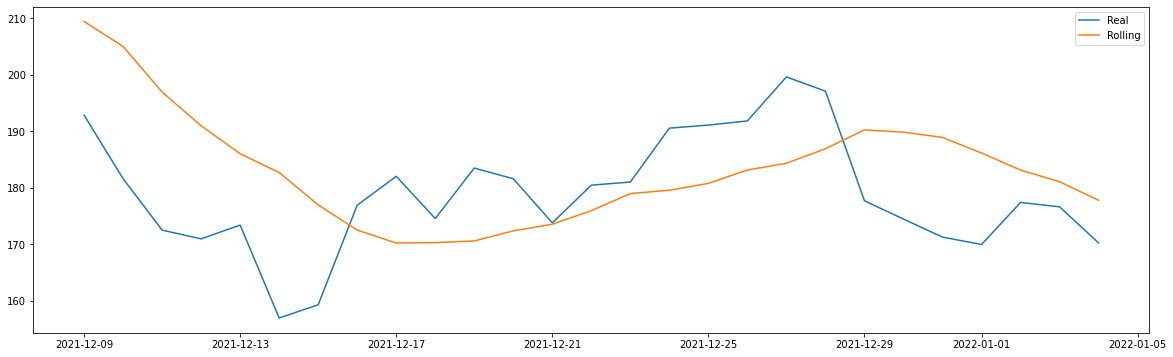

In [110]:
print(MAPE(sol_rolling['pred'], sol_rolling['real']) * 100, '%')
plot_graph(Real = sol_rolling['real'], Rolling = sol_rolling['pred'])